In [1]:
%load_ext autoreload
%autoreload 2

# Twitter Sentiment Analysis Project
<font size="4"> Author: Jeffrey Hanif Watson </font>

## Overview:
In recent years, Twitter has emerged as a prominent platform for marketing and targeted advertising. It is also a valuable conduit for the collection of consumer data, and natural language processing (NLP) can provided solutions to companies seeking to track consumer sentiment regarding their brands and products. This project developed and implemented an NLP model to classify tweets as negative or positive. 

Data cleaning and augmentation, eda, modeling, and evaluation were performed, and a random forest classifier was chosen as the the final model for the project. Beacuse we wanted to avoid both false positives and false negatives for this project, an accuracy measure of F1 was employed since it is sensitive to both types of error. Since an F1 score is a mix of both precision and recall (F1=1 means perfect recall and precision), interpretation of the results is more easily described in terms of recall and precision. 

An F1 accuracy score of 0.89 (recall=.85, precision=.94) was attained at the end of the project's modeling process. The recall score of .85 meant that 85% of negative tweets were correctly classified as negative, while the precision score of .94 indicated that 94% of tweets classified as negative were truly negative. An alternate logistic regression model with an F1 accuracy score of 0.89 (recall=.83, precision=.97) is also available for use by interested parties.

## Business Understanding:
Companies can benefit from understanding how consumers perceive their brands and products, and sentiment analysis of text data from twitter can help provide this knowledge in a timely manner. A surge in negative sentiment would indicate a crisis of some sort that would need to be addressed quickly, and thus negative sentiment was deemed to be the most important class for modeling purposes in the project. However, data on the level of positive sentiment is still very valuable information, so a model that captures both sentiments as accurately as possible is most desirable.  

## Data Understanding:
The baseline data for this project consists of a csv file containing 9,093 rows of text data (tweets, brand/product ids, sentiments labels) originally sourced from [Twitter](https://twitter.com/?lang=en) and collected into the [crowdflower/brands-and-product-emotions](https://data.world/crowdflower/brands-and-product-emotions) dataset. From the overwhelming amount of SXSW hashtags, and numerous references to the iPad 2 (which was released on March 2nd, 2011), it appears that the data was collected during the 2011 South by Southwest festival (which ran from March 11th to March 20th). The data contained ternary (positive, neutral, negative) sentiment data which was filtered down to binary (positive, negative) classes for modeling purposes. 

During the modeling process, the class imbalance in the data was shown to interfer with model performance, and additional negative sentiment data was used to augment the baseline data. 1,117 rows of negative general topic tweets were obtained from [Kaggle](https://www.kaggle.com/shashank1558/preprocessed-twitter-tweets), and an additional 1,219 negative apple tweets were procured from [data.world](https://data.world/crowdflower/apple-twitter-sentiment). This data augmentation greatly improved model performance.

## Package Imports & Setup 
Importing the required packages, setting the project path and notebook styling.

In [2]:
# imports
import os, sys

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

from src import visualizations as v
from src import functions as f
from src import classes as c 

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='Blues_r')
pd.options.display.max_rows = 300

# EDA

#### Importing the Baseline EDA Data

In [3]:
path = os.path.join(gparent, 'data/processed', 'report_baseline_viz.csv')
df = pd.read_csv(path, encoding='unicode_escape')

#### Baseline Data Frame Info 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8908 entries, 0 to 8907
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   emotion        8908 non-null   object
 1   stems          8908 non-null   object
 2   lemmas         8908 non-null   object
 3   tweet          8908 non-null   object
 4   brand_product  3271 non-null   object
 5   hashtags       8899 non-null   object
dtypes: object(6)
memory usage: 417.7+ KB


## Class Balance of the Baseline Data

In [5]:
df.emotion.value_counts(normalize=True)

Neutral     0.602941
Positive    0.333184
Negative    0.063875
Name: emotion, dtype: float64

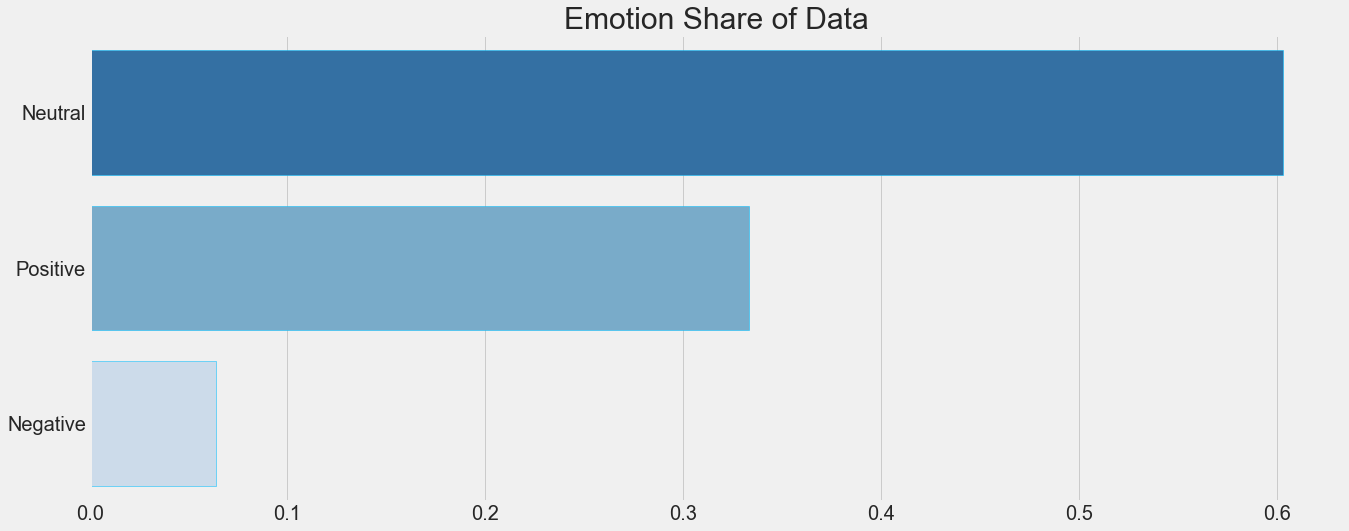

In [6]:
v.emotion_freqs(df)

<font size="4">`Neutral` accounts for 60% of the data.</font>

<font size="4">`Positive`                   accounts for 33% of the data.</font>

<font size="4">`Negative`                   accounts for 6% of the data.</font>

<font size="4">Positive and negative tweets are both are under-represented in the  data, with negative tweets being extremely under-represented (an order of magnitude less common than the other two classes).</font>

## Emotions by Brand

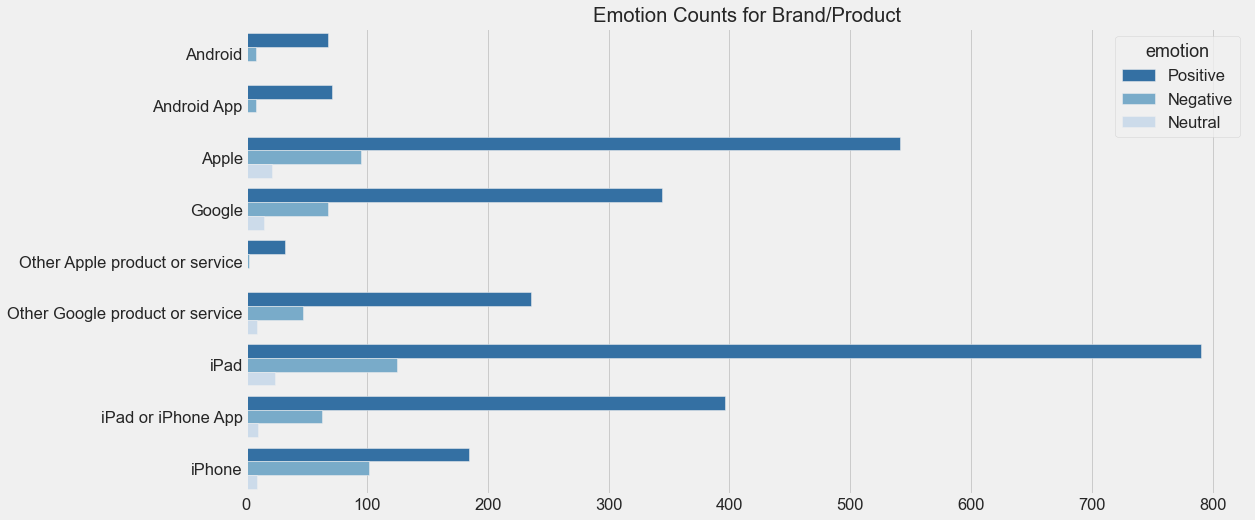

In [7]:
v.brand_emotions(df)

<font size="4">Apple dominates the tweets with `iPad`, `Apple`, and `iPad or iPhone App` being the subjects of the most tweets. Tweets about product and brands have a strong postive skew, with the only exception being tweets about the iPhone. The brand value `iPhone` has a much more mixed ratio of postives and negatives</font>

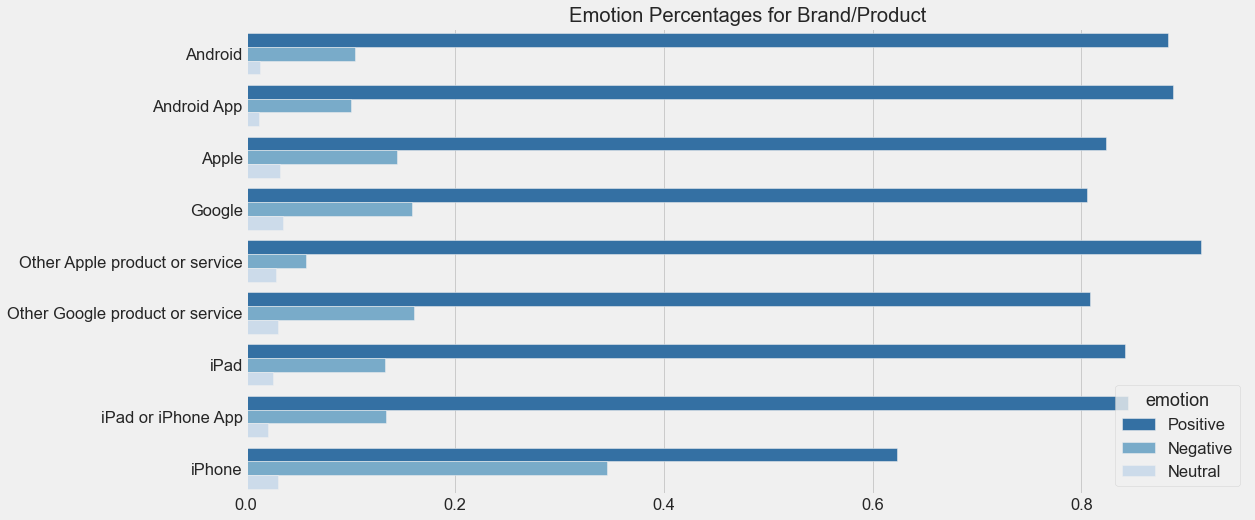

In [8]:
v.brand_emotion_n(df)

## Word Clouds

## Splitting Emotions for Word Clouds

In [9]:
# separating the the emotions
positive = df[df['emotion']=='Positive']
negative = df[df['emotion']=='Negative']
neutral = df[df['emotion']=='Neutral']

In [10]:
# censoring profanity in the tweets
pos_words = f.cloud_cleaner_lem(positive.lemmas)
neg_words = f.cloud_cleaner_lem(negative.lemmas)
neu_words = f.cloud_cleaner_lem(neutral.lemmas)

## Positive Word Cloud
The size of the word indicates its relative frequency in `Positive` tweets.

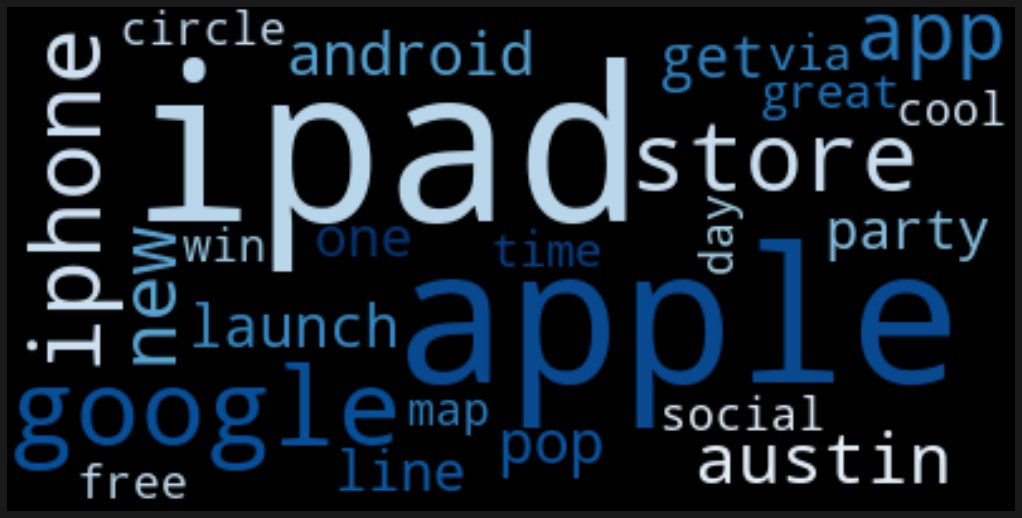

In [11]:
v.word_cloud(pos_words, 25)

<font size="4">`ipad`, `apple`, and `google` are the most used words in `Positive` tweets.</font>

## Negative Word Cloud
The size of the word indicates its relative frequency in `Negative` tweets.

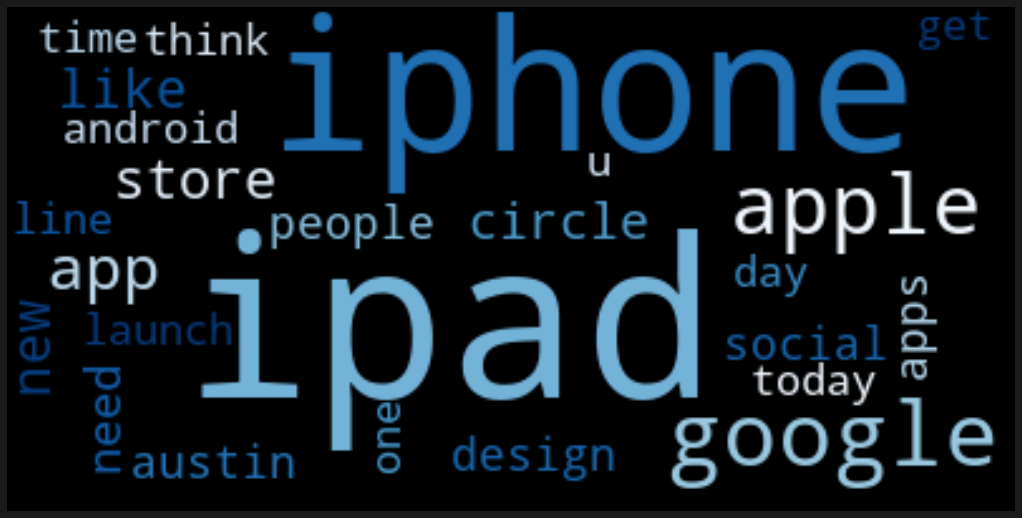

In [12]:
v.word_cloud(neg_words, 25)

<font size="4">`iphone`, `ipad`, and `google` are the most used words in `Negative` tweets.</font>

## Neutral Word Cloud
The size of the word indicates its relative frequency in `Neutral` tweets.

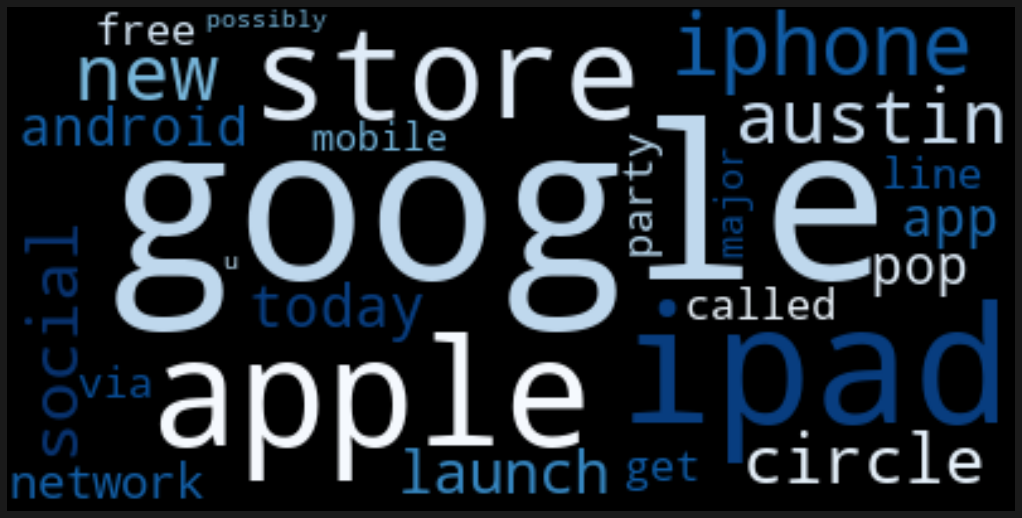

In [13]:
v.word_cloud(neu_words, 25)

<font size="4">`google`, `ipad`, and `apple` are the most used words in `Neutral` tweets.</font>

# Modeling

## Importing the Baseline Modeling Data

In [14]:
path = os.path.join(gparent, 'data/processed', 'report_baseline.csv')
df = pd.read_csv(path, encoding='unicode_escape')

#### Baseline Data Frame Info

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3537 entries, 0 to 3536
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   X_lem   3537 non-null   object
 1   y_lem   3537 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 55.4+ KB


## Splitting `data` & `target` and Creating Train-Test Split
<font size="4">`y_lem` column values = {1: 'negative', 0: 'positive'}</font>

In [16]:
# Creating data & target
X_lem = df.X_lem
y_lem = df.y_lem

In [17]:
# random_state = 2021
X_train, X_test, y_train, y_test = f.splitter(X_lem,
                                               y_lem)                                                                   

## Preprocessing and Harness Objects
An F1 scoring object and modeling harness were instantiated to cross validate, record, and display the modeling results.

In [18]:
# creating f1 scorer
f1 = f.f1

In [19]:
# creating a harness for cross validation
modeling = c.Harness(f1)

# Baseline Model
A baseline model was created from a pipeline consisting of a TFIDF vectorizer and a logistic regression classifier.

#### Loading, Fitting & Scoring Model

In [20]:
# setting the path
path = os.path.join(gparent, 'models', 'baseline_model.pkl')

In [21]:
# loading the model
file = open(path, 'rb')
baseline = pickle.load(file)
file.close()

In [22]:
# fitting the model
baseline.fit(X_train, y_train);

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


## 5-Fold Cross-Validation: Average F1=0.10

In [23]:
# checking cross val scores
modeling.report(baseline, X_train, y_train, 'Baseline Logistic Regression', 'unbalanced data')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Baseline Logistic Regression has an average F1 of 0.10159590287582469


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


array([0.06741573, 0.10869565, 0.13186813, 0.11111111, 0.08888889])

## Scoring the Baseline Model on Test Data

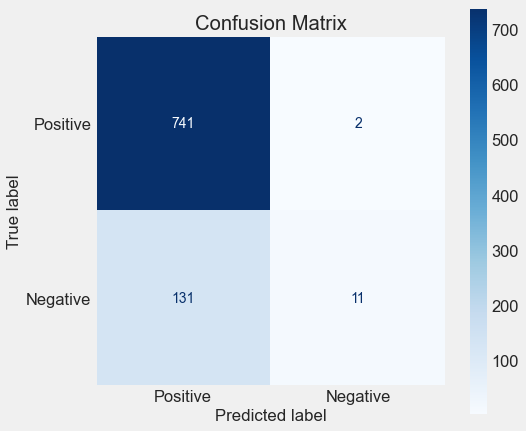

,F1,Recall,Precision
0,0.141935,0.077465,0.846154


In [24]:
f.confusion_report(baseline, X_test, y_test)

### Baseline Scores: F1 = 0.14, Recall = .08, Precision = .85

#### Score Interpretation
Since we want to avoid both false positives and false negatives for this project, a metric of F1 was employed because it is sensitive to both types of error. Also, because F1 is a mix of both precision and recall, the interpretation of the results is more easily described in terms of recall and precision. Overall, the performance of the model very poor.
- From the confusion matrix we see that the baseline model is classifying nearly everything as the majority class.
- A recall score of .08 means that 8% of negative tweets were correctly classified as negative. 
- A precision score of .85 indicates that 85% of tweets classified as negative were truly negative.

## Coefficients of the Top 30 Features 

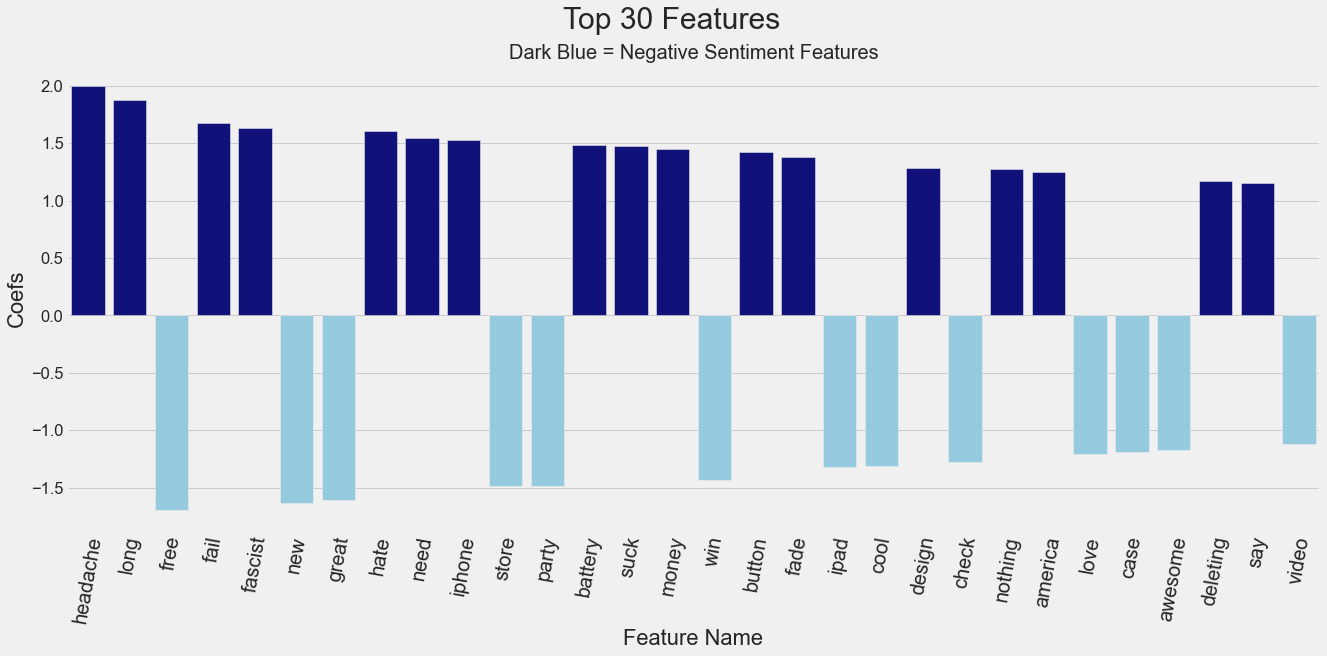

In [25]:
v.base_coefs(baseline)

## Notes of the Features
`headache`, `long`, and `fail` are the top features driving `Negative` classifications, while `free`, `new`, and `great` drive `Positive` classifications.

## Baseline Relative Odds

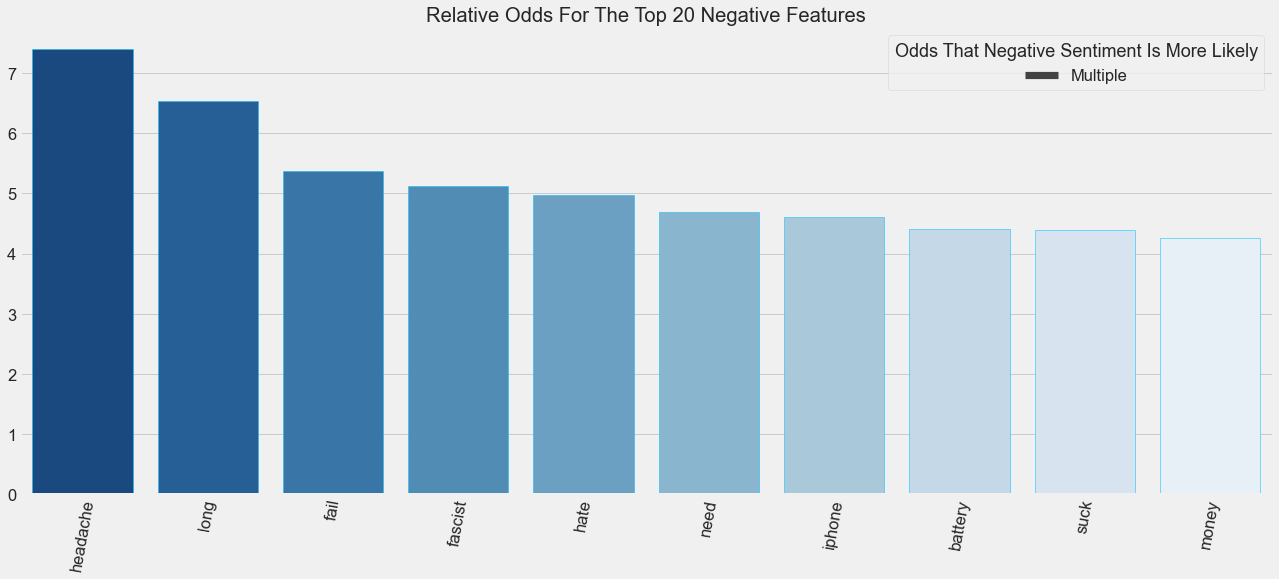

In [26]:
v.base_neg_odds(baseline)

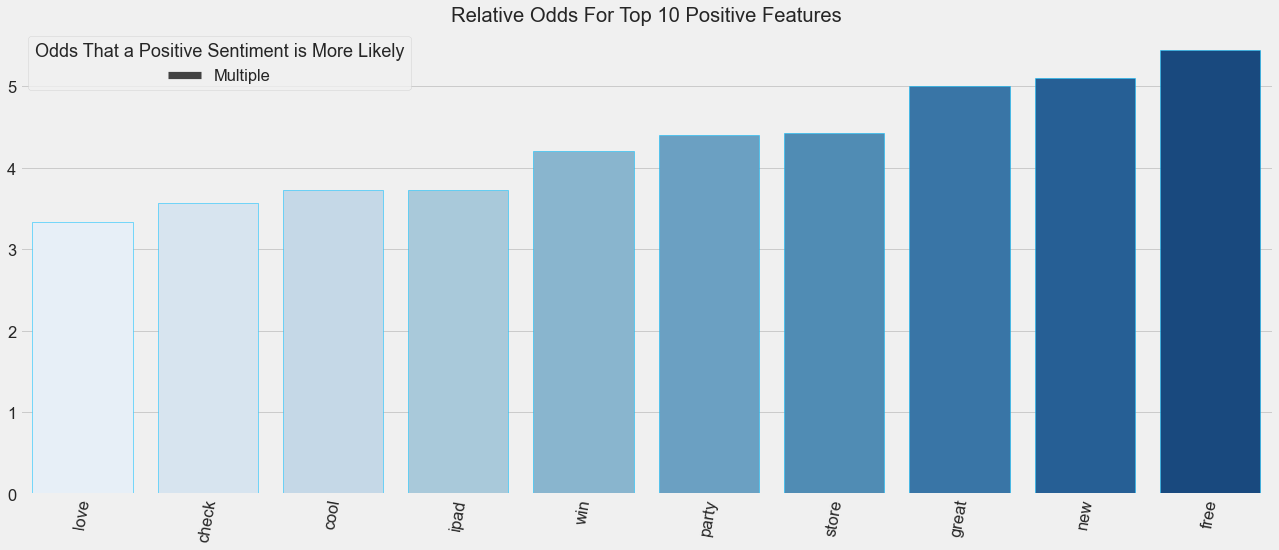

In [27]:
v.base_pos_odds(baseline)

## Interpretation of the Odds
If the assumptions of logistic regression were met by the model, we could numerically quantify the effect of each feature on the model. However, since it is beyond the scope of the project to check that the model meets the underlying assumptions of logistic regression, the most we can say about the features above are their relative importances to the model. A higher bar means more importance of the feature to the model. 

Again, `headache`, `long`, and `fail` are the top features driving `Negative` classifications, while `free`, `new`, and `great` drive `Positive` classifications.

### Data Augmentation & Intermediate Models
The poor performance of the baseline model was largely due the the extreme class imbalance of the original data, so minority class oversampling and SMOTE methods were implemented. These strategies provided improved performance in the baseline model, but the results were still unsatisfactory.  Various other model types were tested with the oversampled data, but the performance of these alternative models was also poor.

In the end, additional negative sentiment data obtained from [Kaggle](https://www.kaggle.com/shashank1558/preprocessed-twitter-tweets) and [data.world](https://data.world/crowdflower/apple-twitter-sentiment) were used to augment the baseline data. This new data greatly imroved the performance of all the models and the final results are detailed below.

## Importing the Augmented EDA Data

In [28]:
path = os.path.join(gparent, 'data/processed', 'report_aug_viz.csv')
df = pd.read_csv(path, encoding='unicode_escape')

#### Baseline Data Frame Info

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11242 entries, 0 to 11241
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   emotion        11242 non-null  object
 1   stems          11242 non-null  object
 2   lemmas         11242 non-null  object
 3   tweet          11242 non-null  object
 4   brand_product  3271 non-null   object
 5   hashtags       9236 non-null   object
dtypes: object(6)
memory usage: 527.1+ KB


## Class Balance of the Augmented Data

In [30]:
df.emotion.value_counts(normalize=True)

Neutral     0.477762
Positive    0.264010
Negative    0.258228
Name: emotion, dtype: float64

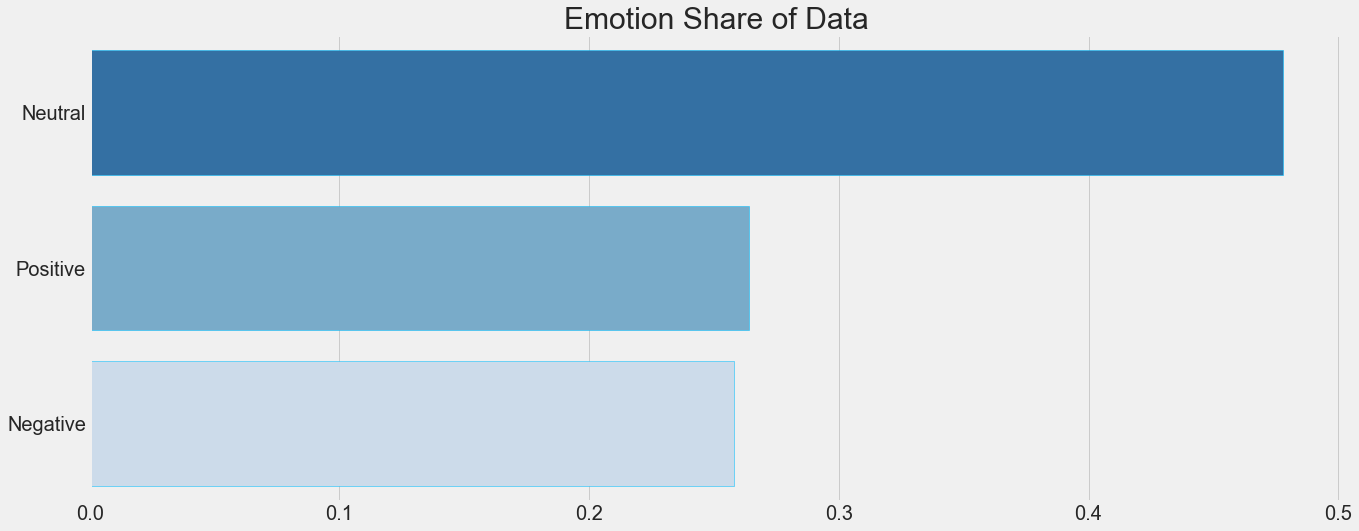

In [31]:
v.emotion_freqs(df)

<font size="4">`Neutral` accounts for 48% of the data.</font>

<font size="4">`Positive`                   accounts for 26% of the data.</font>

<font size="4">`Negative`                   accounts for 26% of the data.</font>

<font size="4">The class balance of the augmented data is much more resonable for modeling purposes.</font> 

## Splitting Emotions for Word Clouds

In [32]:
# separating the the emotions
positive = df[df['emotion']=='Positive']
negative = df[df['emotion']=='Negative']
neutral = df[df['emotion']=='Neutral']

In [33]:
# censoring swear words for word clouds
pos_words = f.cloud_cleaner_lem(positive.lemmas)
neg_words = f.cloud_cleaner_lem(negative.lemmas)
neu_words = f.cloud_cleaner_lem(neutral.lemmas)

## Word Clouds for Augmented Data

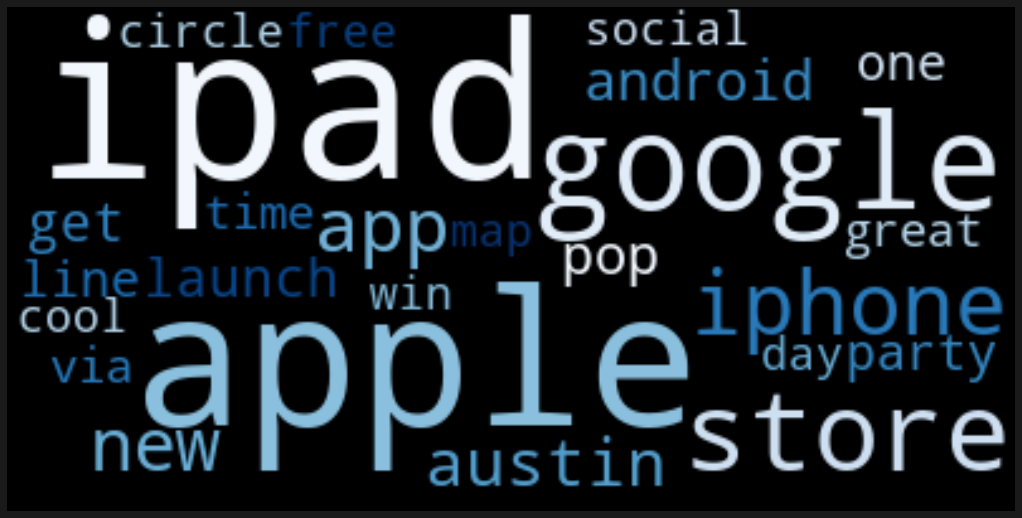

In [34]:
v.word_cloud(pos_words, 25)

<font size="4">`ipad`, and `apple` are the most used words in `Positive` tweets.</font>

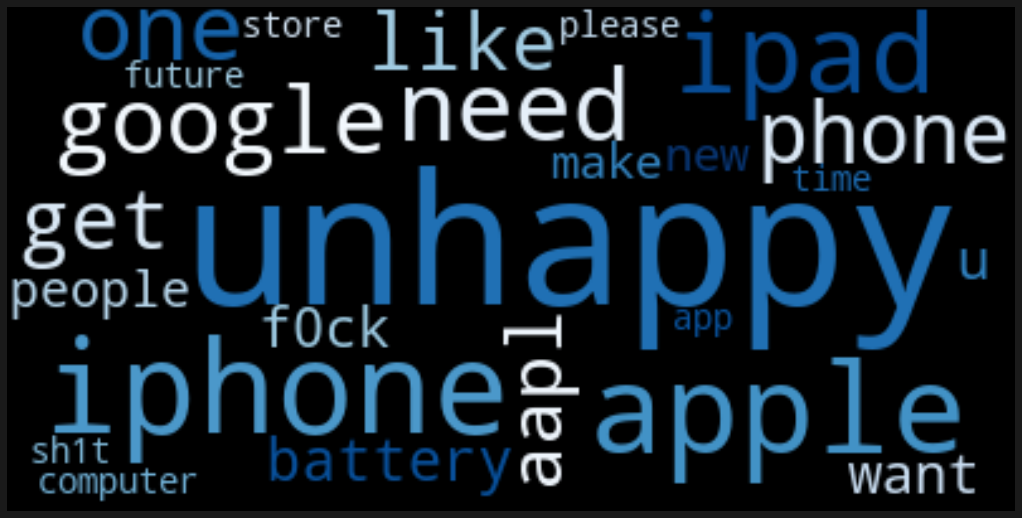

In [35]:
v.word_cloud(neg_words, 25)

<font size="4">`unhappy`, `apple`, and `iphone` are the most used words in `Negative` tweets.</font>

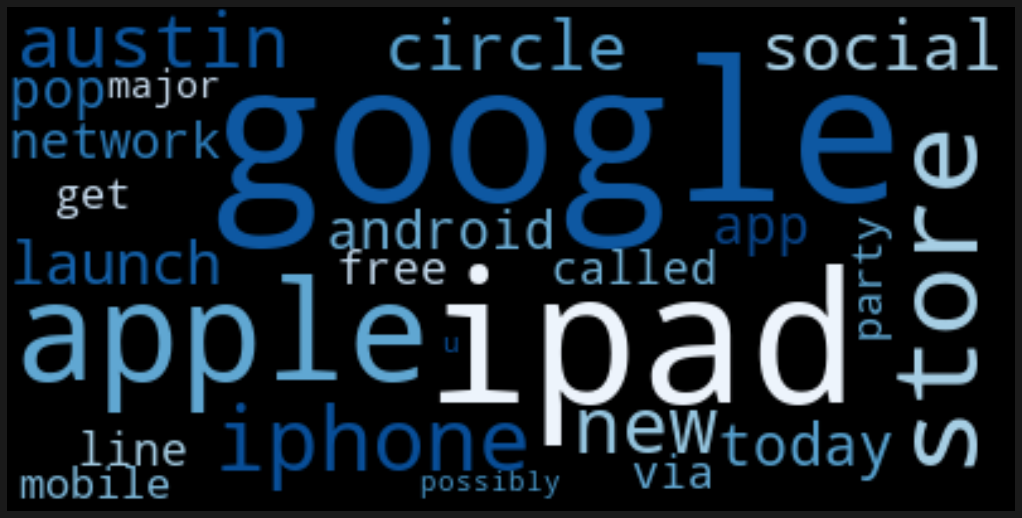

In [36]:
v.word_cloud(neu_words, 25)

<font size="4">`google` and `ipad`, are the most used words in `Neutral` tweets.</font>

## Loading Augmented Modeling Data

In [37]:
path = os.path.join(gparent, 'data/processed', 'report_aug.csv')
df = pd.read_csv(path, encoding='unicode_escape')

## Splitting `data` & `target` and Creating Train-Test Split
<font size="4">`y_lem_aug` column values = {1: 'negative', 0: 'positive'}</font>

In [38]:
# Creating data & target
X_lem_aug = df.X_lem_aug
y_lem_aug = df.y_lem_aug

In [39]:
# train-test split
X_aug_train, X_aug_test, y_aug_train, y_aug_test = f.splitter(X_lem_aug,
                                                               y_lem_aug)            

# MVP Model: 
<font size="4">Random Forest CLF Tuned on Augmented Lemmatized Data</font>

Again, a TFIDF vectorizer was implemented for feature engineering and vectorization.

#### Loading & Fitting Model

In [40]:
# setting the path
path = os.path.join(gparent, 'models', 'MVP_model.pkl')

# loading the model
file = open(path, 'rb')
tuned_rf_aug = pickle.load(file)
file.close()

# fitting model
tuned_rf_aug.fit(X_aug_train, y_aug_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 4), use_idf=False)),
                ('clf',
                 RandomForestClassifier(min_samples_split=10, n_jobs=-1,
                                        random_state=2021))])

## 5-Fold Cross-Validation: Average F1=.89

In [41]:
modeling.report(baseline, X_aug_train, y_aug_train, 'tuned_rf_aug', 'MVP model')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


tuned_rf_aug has an average F1 of 0.8897502471347287


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


array([0.88264059, 0.8856799 , 0.90669856, 0.87651332, 0.89721886])

## Scoring the Model on Test Data

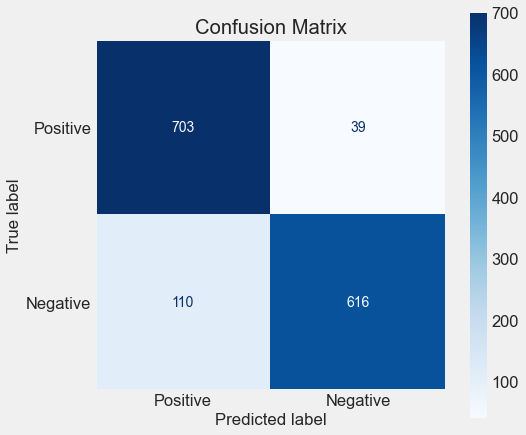

,F1,Recall,Precision
0,0.892107,0.848485,0.940458


In [42]:
f.confusion_report(tuned_rf_aug, X_aug_test, y_aug_test)

## MVP Model Metrics:
<font size="4">Metrics: F1=0.89, Recall=0.85, Precision=0.94</font>

#### Score Interpretation
From the confusion matrix we see that the MVP model still has a little trouble classifying negatives relative to positives, but the overall performance is acceptable.

- The performance of the baseline model has been greatly improved by the addition of new minority class data. 
- A recall score of .85 means that 85% of negative tweets were correctly classified as negative. 
- A precision score of .94 indicates that 94% of tweets classified as negative were truly negative.

## MVP Model Feature Importances

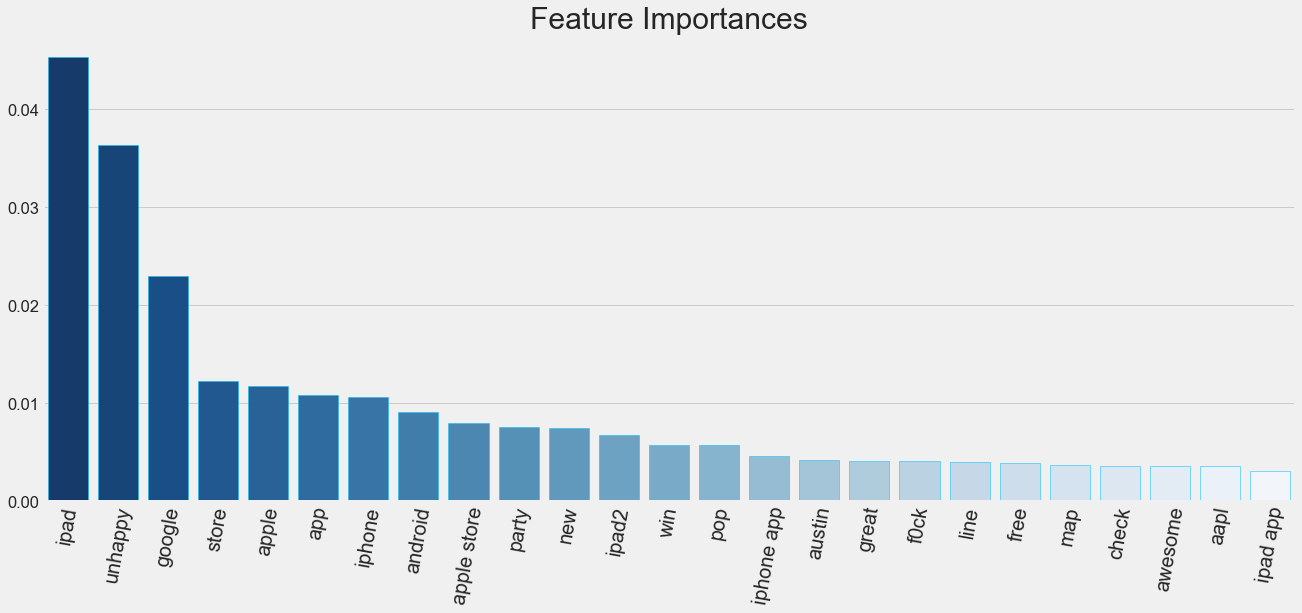

In [43]:
v.feature_plot(tuned_rf_aug)

## Notes on the Features

`Ipad` and `unhappy` are again the most important tokens driving the model, and six of the top ten features are brand signifiers.

# Alternative Model:
<font size="4">Logistic Regression CLF Tuned on Augmented Lemmatized Data</font>

<font size="4">Metrics: F1=0.89, Recall=0.83, Precision=0.97</font>

A TFIDF vectorizer was used for feature engineering and vectorization.

## Loading and Fitting the Model

In [44]:
# setting the path 
path = os.path.join(gparent, 'models', 'ALT_model.pkl')

# loading the model
file = open(path, 'rb')
tuned_LR_aug = pickle.load(file)
file.close()

# fitting the model
tuned_LR_aug.fit(X_aug_train, y_aug_train)

[LibLinear]

/Users/dsbox/opt/anaconda3/envs/nlp_project/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2), use_idf=False)),
                ('clf',
                 LogisticRegression(C=11.288378916846883, max_iter=1000,
                                    n_jobs=-1, random_state=2021,
                                    solver='liblinear', verbose=2))])

## Scoring the Alternative Model on Test Data

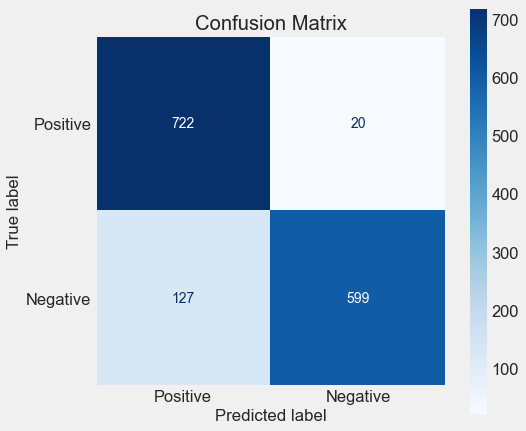

,F1,Recall,Precision
0,0.890706,0.825069,0.96769


In [45]:
f.confusion_report(tuned_LR_aug, X_aug_test, y_aug_test)

## Alternative Model Metrics: 
<font size="4">F1=0.89, Recall=0.83, Precision=0.97</font>

## Tuned Baseline Coefficients & Odds

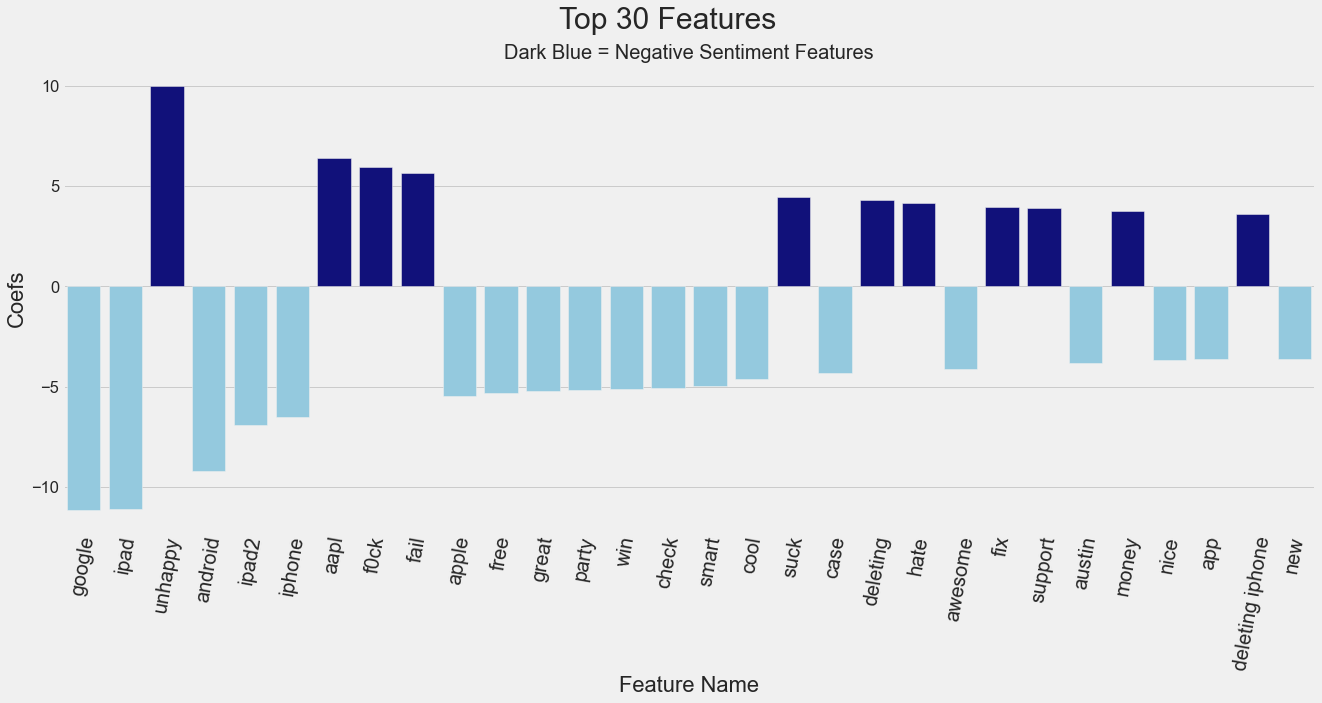

In [46]:
v.base_coefs(tuned_LR_aug)

## Notes on the Features

`Google` & `Ipad` have largest coefficients driving positive classifications, while `unhappy` and `aapl` have the largest coefficients driving negative classifications. Most brand signifiers are still associated with positive classifications.

## Relative Odds

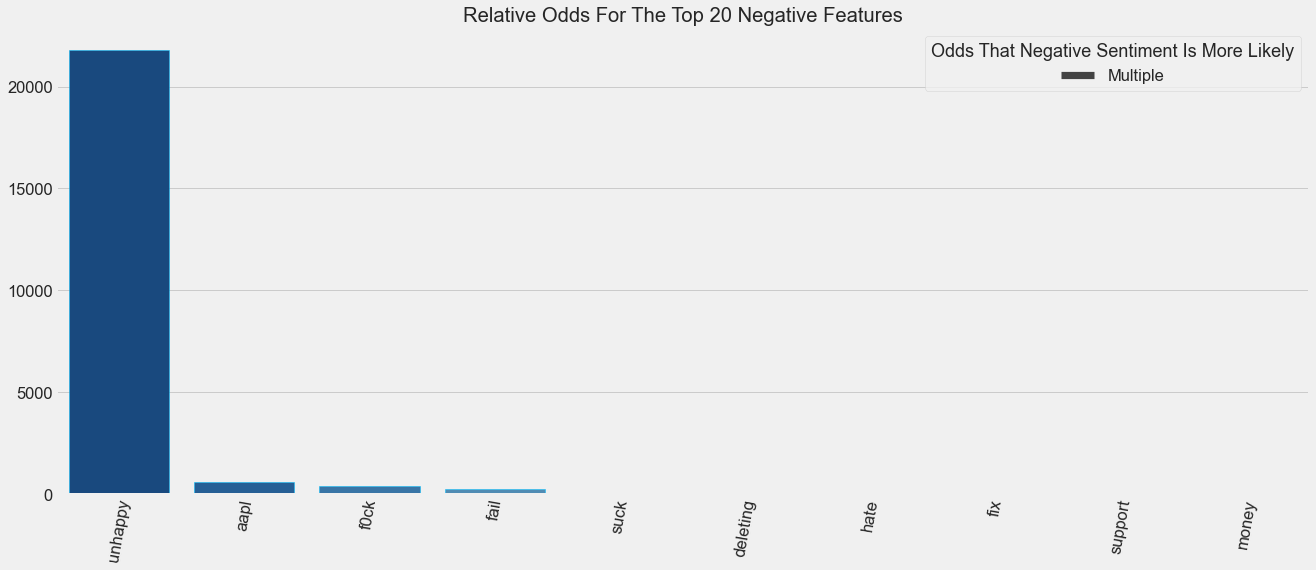

In [47]:
v.base_neg_odds(tuned_LR_aug)

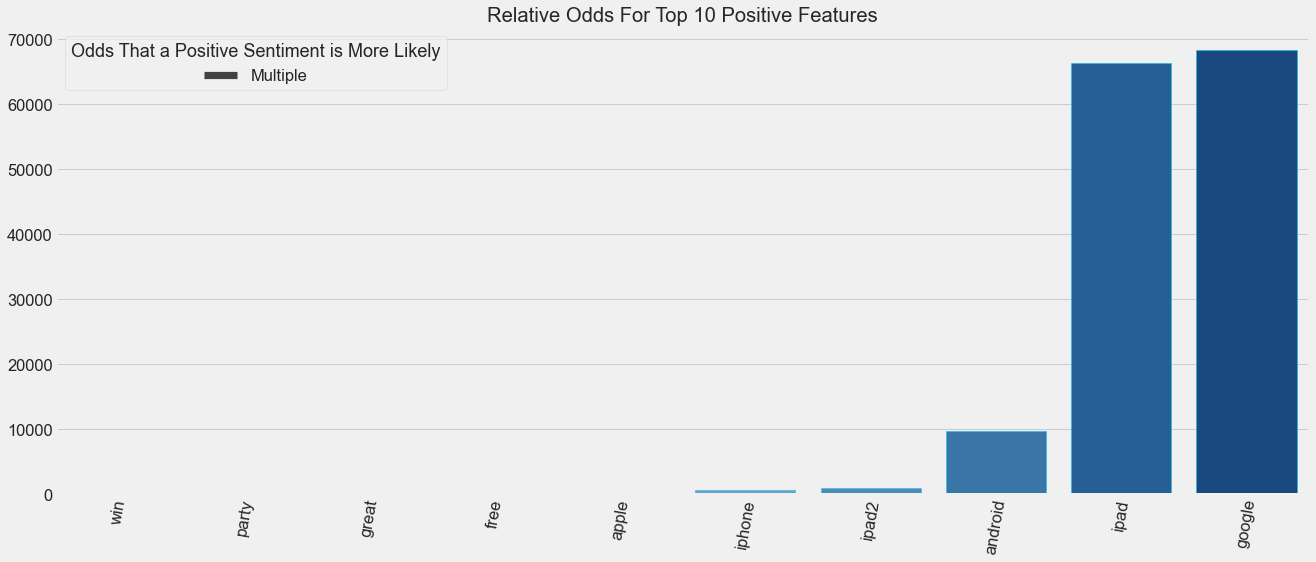

In [48]:
v.base_pos_odds(tuned_LR_aug)

## Interpretation of the Odds
A higher bar means a greater relative importance of the feature to the model. Again, `Google` and `Ipad` are driving positive classifications, while `unhappy` and `aapl` are driving negative classifications. `Google` is the greatest positve factor followed closely by `Ipad`. `Unhappy` increases the odds of a negative classification most significantly.

## Conclusion

A random forest classifier with a F1 accuracy score of 0.89 (recall=.85, precision=.94) was attained at the end of the modeling process and chosen as the final model of the project. The recall score of .85 meant that 85% of negative tweets were correctly classified as negative, and the precision score of .94 indicated that 94% of tweets classified as negative were truly negative. An alternate logistic regression model with an F1 accuracy score of 0.89 (recall=.83, precision=.97) is also available for use by interested parties.

## Next Steps

Next steps for the project include:
- Tuning an XGBoost classifier. 
- Tuning an RNN classifier.
- Implementing a multiclass classifier and adding neutral tweets to the model. 
- Further investigating the logistic regression model's adherence to the underlying assumptions of logistic regression.